In [1]:
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from util_functions import (
    camera_intrinsic,
    projection_matrix,
    projectpoints,
    normalize2d,
    crossProduct,
    pi,
    invPi
)

np.set_printoptions(precision=4)

In [2]:
# Ex 4.1
# Find projection matrix and projections
f = 1000
resolution = (1920, 1080)
principal_point = (resolution[0] / 2, resolution[1] / 2)
K = camera_intrinsic(f, principal_point)
K

array([[1000.,    0.,  960.],
       [   0., 1000.,  540.],
       [   0.,    0.,    1.]])

In [3]:
R = np.array(
    [
        [np.sqrt(0.5), -np.sqrt(0.5), 0],
        [np.sqrt(0.5), np.sqrt(0.5), 0],
        [0, 0, 1],
    ]
)
t = np.array([[0, 0, 10]]).T
cam_pos = np.hstack((R,t))
P = projection_matrix(K, R, t)
print(P)

[[ 7.0711e+02 -7.0711e+02  9.6000e+02  9.6000e+03]
 [ 7.0711e+02  7.0711e+02  5.4000e+02  5.4000e+03]
 [ 0.0000e+00  0.0000e+00  1.0000e+00  1.0000e+01]]


In [4]:
Q = np.array(
    [(x, y, z) for x in [0, 1] for y in [0, 1] for z in [0, 1]]
).T  # 3 x n
Q

array([[0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 1, 0, 1]])

In [5]:

q = projectpoints(K, cam_pos, Q)
with np.printoptions(precision=3):
    print(q)

[[ 960.     960.     889.289  895.718 1030.711 1024.282  960.     960.   ]
 [ 540.     540.     610.711  604.282  610.711  604.282  681.421  668.565]]


In [6]:
# Ex 4.2
# Estimate projection matrix
def pest(Q, q, normalize=False):
    """
    Estimate projection matrix using direct linear transformation.

    Args:
        Q : 3 x n array of 3D points
        q : 2 x n array of 2D points
        normalize : bool, whether to normalize the 2D points

    Returns:
        P : 3 x 4 projection matrix
    """
    if Q.shape[0] != 3:
        raise ValueError("Q must be a 3 x n array of 3D points")
    if q.shape[0] != 2:
        raise ValueError("q must be a 2 x n array of 2D points")

    if normalize:
        q, T = normalize2d(q)

    q = pi(q)  # 3 x n
    Q = pi(Q)  # 4 x n
    n = Q.shape[1]  # number of points
    B = []
    for i in range(n):
        Qi = Q[:, i]
        qi = q[:, i]
        # Xi, Yi, Zi = Qi
        # xi, yi, _ = qi
        # Bi = np.array([[0, -Xi, Xi*yi, 0, -Yi, Yi*yi, 0, -Zi, Zi*yi, 0, -1, yi],
        #                [Xi, 0, -Xi*xi, Yi, 0, -Yi*xi, Zi, 0, -Zi*xi, 1, 0, -xi],
        #                [-Xi*yi, Xi*xi, 0, -Yi*yi, Yi*xi, 0, -Zi*yi, Zi*xi, 0, -yi, xi, 0]])
        Bi = np.kron(Qi, crossProduct(qi))
        B.append(Bi)
    B = np.array(B).reshape(3 * n, 12)
    U, S, Vt = np.linalg.svd(B)
    P = Vt[-1].reshape(4, 3)
    P = P.T
    if normalize:
        P = np.linalg.inv(T) @ P
    return P

In [7]:
P_est = pest(Q, q)
print("Estimated P:\n", P_est)

Estimated P:
 [[-6.3364e-02  6.3364e-02 -8.6026e-02 -8.6026e-01]
 [-6.3364e-02 -6.3364e-02 -4.8389e-02 -4.8389e-01]
 [ 1.1858e-17 -1.5801e-16 -8.9610e-05 -8.9610e-04]]


In [8]:
def compute_rmse(q_true, q_est):
    """
    Returns the root mean square error between the true and estimated 2D points.

    Args:
        q_true: 2 x n array of true 2D points
        q_est: 2 x n array of estimated 2D points
    """
    if q_true.shape[0] != 2 or q_est.shape[0] != 2:
        raise ValueError("q_true and q_est must be 2 in the first dimension")
    if q_true.shape[1] != q_est.shape[1]:
        raise ValueError("q_true and q_est must have the same number of points")
    se = (q_est - q_true) ** 2
    return np.sqrt(np.mean((se)))

In [9]:
# Compute reprojection error
q_est = P_est @ pi(Q)
rmse = compute_rmse(q, invPi(q_est))
print("RMSE: ", rmse)  # should be close to 0

RMSE:  1.1629671387309195e-10


In [10]:
# Normalize points before estimating P
P_est = pest(Q, q, normalize=True)
q_est = P_est @ pi(Q)

rmse = compute_rmse(q, invPi(q_est))
print("RMSE: ", rmse)
# Normalizing the points should improve reprojection error slightly.

RMSE:  1.0634429903501374e-13


In [11]:
# Ex 4.3
# Simulate 3D points on a checkerboard
def checkerboard_points(n, m):
    """
    Generate 3D points of a checkerboard with n x m squares.

    Returns:
        points : 3 x (n*m) array of 3D points
    """
    points = np.array(
        [
            (i - (n - 1) / 2, j - (m - 1) / 2, 0)
            for i in range(n)
            for j in range(m)
        ]
    ).T
    return points

In [12]:
Qcb = checkerboard_points(5, 4)
print(Qcb.shape)
print(Qcb)

(3, 20)
[[-2.  -2.  -2.  -2.  -1.  -1.  -1.  -1.   0.   0.   0.   0.   1.   1.
   1.   1.   2.   2.   2.   2. ]
 [-1.5 -0.5  0.5  1.5 -1.5 -0.5  0.5  1.5 -1.5 -0.5  0.5  1.5 -1.5 -0.5
   0.5  1.5 -1.5 -0.5  0.5  1.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]]


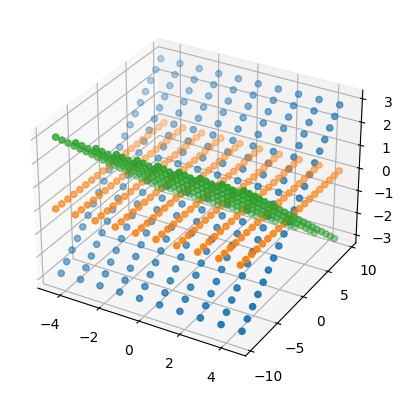

In [13]:
# Ex 4.4
# Apply rotation and translation to the simulated 3D points
from scipy.spatial.transform import Rotation

Ra = Rotation.from_euler("xyz", [np.pi / 10, 0, 0]).as_matrix()
Rb = Rotation.from_euler("xyz", [0, 0, 0]).as_matrix()
Rc = Rotation.from_euler("xyz", [-np.pi / 10, 0, 0]).as_matrix()

# Simulated 3D points for different views
Q_omega = checkerboard_points(10, 20)
Qa = Ra @ Q_omega  # 3 x n
Qb = Rb @ Q_omega
Qc = Rc @ Q_omega

cam_pos_a = np.hstack((Ra, t))
cam_pos_b = np.hstack((Rb, t))
cam_pos_c = np.hstack((Rc, t))

qa = projectpoints(K, cam_pos_a, Qa)
qb = projectpoints(K, cam_pos_b, Qb)
qc = projectpoints(K, cam_pos_c, Qc)

# Visualize the 3 views
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(Qa[0, :], Qa[1, :], Qa[2, :])
ax.scatter(Qb[0, :], Qb[1, :], Qb[2, :])
ax.scatter(Qc[0, :], Qc[1, :], Qc[2, :])
plt.show()

In [14]:
#part 2.8 : include normalization in the homography estimation
def hest(q1, q2, normalize=False):
    """
    Calculate the homography matrix from n sets of 2D points
    q1 : 2 x n, 2D points in the first image
    q2 : 2 x n, 2D points in the second image
    H : 3 x 3, homography matrix
    """
    if q1.shape[1] != q2.shape[1]:
        raise ValueError("Number of points in q1 and q2 must be equal")
    if q1.shape[1] < 4:
        raise ValueError("At least 4 points are required to estimate a homography")
    if q1.shape[0] != 2 or q2.shape[0] != 2:
        raise ValueError("q1 and q2 must have 2 rows")

    if normalize:
        q1, T1 = normalize2d(q1)
        q2, T2 = normalize2d(q2)
    n = q1.shape[1]
    B = []
    for i in range(n):
        x1, y1 = q1[:, i]
        x2, y2 = q2[:, i]
        Bi = np.array(
            [
                [0, -x2, x2 * y1, 0, -y2, y2 * y1, 0, -1, y1],
                [x2, 0, -x2 * x1, y2, 0, -y2 * x1, 1, 0, -x1],
                [-x2 * y1, x2 * x1, 0, -y2 * y1, y2 * x1, 0, -y1, x1, 0],
            ]
        )
        B.append(Bi)
    B = np.array(B).reshape(-1, 9)
    U, S, Vt = np.linalg.svd(B)
    H = Vt[-1].reshape(3, 3)
    if normalize:
        H = np.linalg.inv(T1) @ H @ T2
    return H

In [15]:
# Ex 4.5
def estimate_homographies(Q_omega, qs):
    """
    Estimate homographies for each view.

    Args:
        Q_omega : 3 x (nxm) array of untransformed 3D points
        qs : list of arrays corresponding to each view

    Returns:
        Hs : list of 3x3 homographies for each view
    """
    Hs = []
    Q = Q_omega[:2]  # remove 3rd row of zeros
    for q in qs:
        H = hest(q, Q)  # TODO: why hest(q, Q) instead of hest(Q, q)?
        Hs.append(H)
    return Hs

In [16]:
qs = [qa, qb, qc]
Hs = estimate_homographies(Q_omega, qs)
Hs

[array([[-8.9836e-02,  3.0692e-16, -2.8820e-17],
        [-5.0692e-02, -1.0119e-01, -5.2804e-05],
        [-8.6243e-01, -4.8512e-01, -8.9836e-04]]),
 array([[ 9.0050e-02,  2.2271e-16,  1.2582e-17],
        [-1.8348e-16,  9.0050e-02,  6.6805e-17],
        [ 8.6448e-01,  4.8627e-01,  9.0050e-04]]),
 array([[-9.0211e-02,  2.3519e-16,  8.2438e-17],
        [ 5.0904e-02, -4.4349e-02,  5.3025e-05],
        [-8.6602e-01, -4.8714e-01, -9.0211e-04]])]

In [17]:
Q_omega_h = pi(Q_omega[:2])  # Q_omega without z, in homogenous

print(Q_omega_h.shape)
qa_est = Hs[0] @ Q_omega_h
qb_est = Hs[1] @ Q_omega_h
qc_est = Hs[2] @ Q_omega_h

print("qa_est", qa_est[-1])
qa_est = qa_est[:2] / qa_est[-1]
qb_est = qb_est[:2] / qb_est[-1]
qc_est = qc_est[:2] / qc_est[-1]

# Compute reprojection error
print(f"qa: \n {qa}")
print(f"qa: \n {qa_est}")

print("RMSE: ", compute_rmse(qa, qa_est))
print("RMSE: ", compute_rmse(qb, qb_est))
print("RMSE: ", compute_rmse(qc, qc_est))

(3, 200)
qa_est [ 8.4886  8.0035  7.5184  7.0333  6.5482  6.063   5.5779  5.0928  4.6077
  4.1226  3.6375  3.1524  2.6672  2.1821  1.697   1.2119  0.7268  0.2417
 -0.2435 -0.7286  7.6262  7.1411  6.656   6.1709  5.6857  5.2006  4.7155
  4.2304  3.7453  3.2602  2.775   2.2899  1.8048  1.3197  0.8346  0.3495
 -0.1357 -0.6208 -1.1059 -1.591   6.7638  6.2787  5.7935  5.3084  4.8233
  4.3382  3.8531  3.368   2.8828  2.3977  1.9126  1.4275  0.9424  0.4573
 -0.0278 -0.513  -0.9981 -1.4832 -1.9683 -2.4534  5.9013  5.4162  4.9311
  4.446   3.9609  3.4758  2.9906  2.5055  2.0204  1.5353  1.0502  0.5651
  0.08   -0.4052 -0.8903 -1.3754 -1.8605 -2.3456 -2.8307 -3.3159  5.0389
  4.5538  4.0687  3.5836  3.0985  2.6133  2.1282  1.6431  1.158   0.6729
  0.1878 -0.2974 -0.7825 -1.2676 -1.7527 -2.2378 -2.7229 -3.2081 -3.6932
 -4.1783  4.1765  3.6914  3.2063  2.7211  2.236   1.7509  1.2658  0.7807
  0.2956 -0.1896 -0.6747 -1.1598 -1.6449 -2.13   -2.6151 -3.1002 -3.5854
 -4.0705 -4.5556 -5.0407  3.3141  2

In [18]:
# Ex 4.6
# Estimate b vector
def form_vi(H, a, b):
    """
    Form 1x6 vector vi using H and indices alpha, beta.

    Args:
        H : 3x3 homography
        a, b : indices alpha, beta

    Returns:
        vi : 1x6 vector
    """
    # Use zero-indexing here. Notes uses 1-indexing.
    a = a - 1
    b = b - 1
    vi = np.array(
        [
            H[0, a] * H[0, b],
            H[0, a] * H[1, b] + H[1, a] * H[0, b],
            H[1, a] * H[1, b],
            H[2, a] * H[0, b] + H[0, a] * H[2, b],
            H[2, a] * H[1, b] + H[1, a] * H[2, b],
            H[2, a] * H[2, b],
        ]
    )
    vi = vi.reshape(1, 6)
    return vi


def estimate_b(Hs):
    """
    Estimate b matrix used Zhang's method for camera calibration.

    Args:
        Hs : list of 3x3 homographies for each view

    Returns:
        b : 6x1 vector
    """
    V = []  # coefficient matrix
    # Create constraints in matrix form
    for H in Hs:
        vi_11 = form_vi(H, 1, 1)
        vi_12 = form_vi(H, 1, 2)
        vi_22 = form_vi(H, 2, 2)
        v = np.vstack((vi_12, vi_11 - vi_22))  # 2 x 6
        V.append(v)
    # V = np.array(V) creates the wrong array shape
    V = np.vstack(V)  # 2n x 6
    U, S, bt = np.linalg.svd(V.T @ V)
    b = bt[-1].reshape(6, 1)
    return b


In [19]:
b = estimate_b(Hs)

In [20]:
def b_from_B(B):
    """
    Returns the 6x1 vector b from the 3x3 matrix B.

    b = [B11 B12 B22 B13 B23 B33].T
    """
    if B.shape != (3, 3):
        raise ValueError("B must be a 3x3 matrix")

    b = np.array((B[0, 0], B[0, 1], B[1, 1], B[0, 2], B[1, 2], B[2, 2]))
    b = b.reshape(6, 1)
    return b


In [21]:
B_true = np.linalg.inv(K.T) @ np.linalg.inv(K)
b_true = b_from_B(B_true)

print("b_est:\n", b / np.linalg.norm(b))
print("b_true:\n", b_true / np.linalg.norm(b_true))

b_est:
 [[-9.9685e-01]
 [-8.4149e-14]
 [-5.7482e-14]
 [ 7.8880e-02]
 [ 8.6325e-15]
 [-8.2167e-03]]
b_true:
 [[ 4.5183e-07]
 [ 0.0000e+00]
 [ 4.5183e-07]
 [-4.3376e-04]
 [-2.4399e-04]
 [ 1.0000e+00]]


In [22]:
# Check: v11 b_true == h1.T B_true h1, first -> zero indexing
h1 = Hs[0][:, 0]
v11 = form_vi(Hs[0], 1, 1)

print(v11 @ b_true)
print(h1.T @ B_true @ h1)
# The 2 values should be the same.

[[1.6459]]
1.6459416202323138


In [23]:
# Check: v12 b_true == h1.T B_true h2
h1 = Hs[0][:, 0]
h2 = Hs[0][:, 1]
v12 = form_vi(Hs[0], 1, 2)

print(v12 @ b_true)
print(h1.T @ B_true @ h2)
# The 2 values should be the same.

[[0.9259]]
0.9258501508185188


In [24]:
# Check: v22 b_true == h1.T B_true h2
h2 = Hs[0][:, 1]
v22 = form_vi(Hs[0], 2, 2)

print(v22 @ b_true)
print(h2.T @ B_true @ h2)
# The 2 values should be the same.

[[0.5208]]
0.5207952117300167


In [25]:
# Ex 4.7
# Estimate intrinsic matrix using equations from Zhang's paper
def estimate_intrinsics(Hs):
    """
    Estimate intrinsic matrix using Zhang's method for camera calibration.

    Args:
        Hs : list of 3x3 homographies for each view

    Returns:
        K : 3x3 intrinsic matrix
    """
    b = estimate_b(Hs)
    B11, B12, B22, B13, B23, B33 = b
    # Appendix B of Zhang's paper
    v0 = (B12 * B13 - B11 * B23) / (B11 * B22 - B12**2)
    lambda_ = B33 - (B13**2 + v0 * (B12 * B13 - B11 * B23)) / B11
    alpha = np.sqrt(lambda_ / B11)
    beta = np.sqrt(lambda_ * B11 / (B11 * B22 - B12**2))
    gamma = -B12 * alpha**2 * beta / lambda_
    u0 = lambda_ * v0 / beta - B13 * alpha**2 / lambda_
    # above values are sequences [value], so using [0] below is needed
    K = np.array([[alpha[0], gamma[0], u0[0]], [0, beta[0], v0[0]], [0, 0, 1]])
    return K


In [26]:
K_est = estimate_intrinsics(Hs)
print("K_est:\n", K_est)
print("K_true:\n", K)
# The estimated K should be close to the true K.

K_est:
 [[ 4.4510e-02 -1.5647e-08  7.9130e-02]
 [ 0.0000e+00  1.8536e+05  3.4338e-02]
 [ 0.0000e+00  0.0000e+00  1.0000e+00]]
K_true:
 [[1000.    0.  960.]
 [   0. 1000.  540.]
 [   0.    0.    1.]]


In [27]:
# Ex 4.8
# Estimate extrinsic parameters using equations from the slides
def estimate_extrinsics(K, Hs):
    """
    Estimate extrinsic parameters using Zhang's method for camera calibration.

    Args:
        K : 3x3 intrinsic matrix
        Hs : list of 3x3 homographies for each view

    Returns:
        Rs : list of 3x3 rotation matrices
        ts : list of 3x1 translation vectors
    """
    Kinv = np.linalg.inv(K)
    Rs = []
    ts = []
    for H in Hs:  # H = [h1|h2|h3]
        h1 = H[:, 0]
        h2 = H[:, 1]
        h3 = H[:, 2]
        lambda_ = np.linalg.norm(Kinv @ h1, 2)
        r1 = 1 / lambda_ * Kinv @ h1  # (3,)
        r2 = 1 / lambda_ * Kinv @ h2
        r3 = np.cross(r1, r2)
        t = np.array(1 / lambda_ * Kinv @ h3).reshape(3, 1)  # 3 x 1
        R = np.vstack((r1, r2, r3)).T  # 3 x 3 [r1|r2|r3]
        Rs.append(R)
        ts.append(t)
    Rs = np.array(Rs)
    ts = np.array(ts)
    return Rs, ts


In [28]:
Rs, ts = estimate_extrinsics(K_est, Hs)
print("Rs_true:\n", np.array((Ra, Rb, Rc)))
print("Rs:\n", Rs)

Rs_true:
 [[[ 1.      0.      0.    ]
  [ 0.      0.9511 -0.309 ]
  [ 0.      0.309   0.9511]]

 [[ 1.      0.      0.    ]
  [ 0.      1.      0.    ]
  [ 0.      0.      1.    ]]

 [[ 1.     -0.      0.    ]
  [ 0.      0.9511  0.309 ]
  [-0.     -0.309   0.9511]]]
Rs:
 [[[-4.9026e-01  8.7158e-01 -3.4537e-07]
  [-1.1492e-07 -4.6091e-07 -1.0000e+00]
  [-8.7158e-01 -4.9026e-01  3.2613e-07]]

 [[ 4.9026e-01 -8.7158e-01 -4.2690e-07]
  [-1.6146e-07  3.9898e-07 -1.0000e+00]
  [ 8.7158e-01  4.9026e-01  5.4881e-08]]

 [[-4.9026e-01  8.7158e-01 -3.4537e-07]
  [ 4.3785e-07 -1.4997e-07 -1.0000e+00]
  [-8.7158e-01 -4.9026e-01 -3.0809e-07]]]


In [29]:
print("ts:\n", ts)  # TODO: why [0,0,1] instead of [0,0,0]?


ts:
 [[[ 1.6140e-03]
  [-1.1971e-10]
  [-9.0789e-04]]

 [[-1.6140e-03]
  [-1.6819e-10]
  [ 9.0789e-04]]

 [[ 1.6140e-03]
  [ 4.5609e-10]
  [-9.0789e-04]]]


In [30]:
# Compiling functions
def calibrate_camera(qs, Q):
    """
    Calibrate camera using Zhang's method for camera calibration.

    Args:
        qs : list of arrays corresponding to each view
        Q : 3 x (nxm) array of untransformed 3D points

    Returns:
        K : 3x3 intrinsic matrix
        Rs : list of 3x3 rotation matrices
        ts : list of 3x1 translation vectors
    """
    Hs = estimate_homographies(Q, qs)
    K = estimate_intrinsics(Hs)
    Rs, ts = estimate_extrinsics(K, Hs)
    return K, Rs, ts


In [31]:
# Ex 4.9
# Use the compiled function
K_est, Rs, ts = calibrate_camera(qs, Q_omega)
print("K:\n", K_est)

cam_pos_a = np.hstack((Rs[0], ts[0]))
cam_pos_b = np.hstack((Rs[1], ts[1]))
cam_pos_c = np.hstack((Rs[2], ts[2]))

qa_est = projectpoints(K_est, cam_pos_a, Qa)
qb_est = projectpoints(K_est, cam_pos_b, Qb)
qc_est = projectpoints(K_est, cam_pos_c, Qc)

# Compute reprojection error
print("RMSE: ", compute_rmse(qa, qa_est))
print("RMSE: ", compute_rmse(qb, qb_est))
print("RMSE: ", compute_rmse(qc, qc_est))

K:
 [[ 4.4510e-02 -1.5647e-08  7.9130e-02]
 [ 0.0000e+00  1.8536e+05  3.4338e-02]
 [ 0.0000e+00  0.0000e+00  1.0000e+00]]
RMSE:  1603855.2559757286
RMSE:  902.2225410500663
RMSE:  1603835.9615129372


In [32]:
# Ex 4.10
# Add noise to the 2D points
mu = 0
sd = 1
qa_noise = qa + np.random.normal(mu, sd, qa.shape)
qb_noise = qb + np.random.normal(mu, sd, qb.shape)
qc_noise = qc + np.random.normal(mu, sd, qc.shape)

qs_noise = [qa_noise, qb_noise, qc_noise]
K_est, Rs, ts = calibrate_camera(qs_noise, Q_omega)
print("K_est:\n", K_est)  # should be almost correct
print("K_true:\n", K)

K_est:
 [[0.0447    nan    nan]
 [0.        nan 0.0152]
 [0.     0.     1.    ]]
K_true:
 [[1000.    0.  960.]
 [   0. 1000.  540.]
 [   0.    0.    1.]]


/var/folders/02/ft7cs0yd1n361rhk5nqxspmc0000gn/T/ipykernel_25049/2657426383.py:19: RuntimeWarning: invalid value encountered in sqrt
  beta = np.sqrt(lambda_ * B11 / (B11 * B22 - B12**2))
